In [1]:
import sys
sys.path.append("./../../src")
from visualizer_helper import Visualizer
from cluster_helper import ClusterProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy.sparse import csr_matrix
import scipy
import pickle
import os
from annoy import AnnoyIndex
from scipy.sparse.linalg import inv

from collections import Counter
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
k_neighbors = 50
knn_clusters = 100
keep_k_evecs = 10
drop_k_evecs=2

cluster_assignments = pd.read_csv("./data/CLUSTER_ASSIGNMENTS.csv")
icd9codes = pd.read_csv("../../data/PATIENT_ICD_ICD9_CODES.csv")
patient_icd_binary = pickle.load(open("../../data/PATIENT_ICD_BINARY_SPARSE_CSR.p", 'rb'))
icd9diag = pd.read_csv("../../../mimic/D_ICD_DIAGNOSES.csv.gz")
icd9proc = pd.read_csv("../../../mimic/D_ICD_PROCEDURES.csv.gz")

A = pickle.load(open("./data/A_mknn_K{}_CSR.p".format(k_neighbors), "rb"))

Y_cluster_labels = pickle.load(open("./data/cluster_labels_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))
Y_mc_cluster_labels = pickle.load(open("./data/cluster_labels_mc_K{}_knn{}_topkevecs{}_drop{}.p".format(k_neighbors, knn_clusters, keep_k_evecs, drop_k_evecs), 'rb'))

In [3]:
icd9diag[icd9diag["ICD9_CODE"] == '99741']

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
11754,12370,99741,Ret cholelh fol cholecys,Retained cholelithiasis following cholecystectomy


In [4]:
cluster_assignments[cluster_assignments['CLUSTER'] == 14] 

,SUBJECT_ID,ORIGINAL_INDEX,CLUSTER,MC_CLUSTER
24,64,27,14,0
111,62,121,14,0
235,226,257,14,88
258,267,284,14,24
270,440,296,14,88
...,...,...,...,...
42393,99823,46388,14,0
42436,99923,46434,14,88
42438,99934,46436,14,88
42454,97004,46453,14,88


In [5]:
cp = ClusterProcessor(patient_icd_binary, icd9codes, icd9diag, cluster_assignments, k_neighbors,
                        other_stopwords = ["hypertension", 'disorder'])

In [6]:
cp.top_diseases_in_cluster(cluster=14, topk=10)

,ICD9_CODE,SHORT_TITLE,DISEASE_COUNT
0,5990,Urin tract infection NOS,230
1,5119,Pleural effusion NOS,80
2,9974,9974,77
3,5601,Paralytic ileus,76
4,2875,Thrombocytopenia NOS,71
5,99859,Other postop infection,64
6,5185,5185,59
7,7907,Bacteremia,56
8,0414,0414,54
9,2768,Hypopotassemia,50


,ICD9_CODE,LONG_TITLE,DISEASE_COUNT
0,2720,Pure hypercholesterolemia,207
1,4019,Unspecified essential hypertension,84
2,2449,Unspecified acquired hypothyroidism,46


In [8]:
diag = pd.read_csv("/Users/andrew/Documents/meng/spring/mimic/DIAGNOSES_ICD.csv.gz")

In [9]:
diag[diag['ICD9_CODE'] =='9974']

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
919,312,38,185910,8.0,9974
3368,2872,236,151459,4.0,9974
3543,3210,267,163714,1.0,9974
3648,5351,440,156155,3.0,9974
5218,4996,413,156909,5.0,9974
...,...,...,...,...,...
648496,650197,99817,195557,5.0,9974
648620,650321,99832,192563,2.0,9974
648917,638825,97271,135659,7.0,9974
649578,650769,99923,192053,5.0,9974


In [10]:
icd9diag[icd9diag['ICD9_CODE'] =='9974']

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE


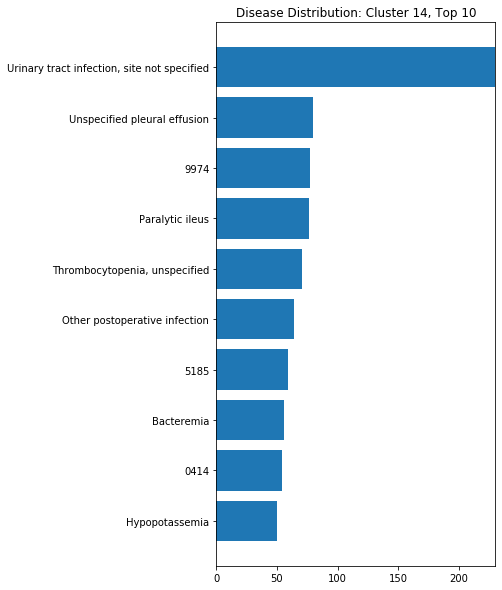

[('5990', 'Urinary tract infection, site not specified', 230),
 ('5119', 'Unspecified pleural effusion', 80),
 ('9974', '9974', 77),
 ('5601', 'Paralytic ileus', 76),
 ('2875', 'Thrombocytopenia, unspecified', 71),
 ('99859', 'Other postoperative infection', 64),
 ('5185', '5185', 59),
 ('7907', 'Bacteremia', 56),
 ('0414', '0414', 54),
 ('2768', 'Hypopotassemia', 50)]

In [11]:
cp.plot_disease_distribution(10, cluster=14)

In [12]:
A_sorted = cp.sort_by_cluster_membership(A, mc_cluster=False)
A_mc_sorted = cp.sort_by_cluster_membership(A, mc_cluster=False)
# pickle.dump(A_sorted, open("./data/A_sorted_K{}.p".format(k_neighbors),"wb"))
# pickle.dump(A_mc_sorted, open("./data/A_mc_sorted_K{}.p".format(k_neighbors),"wb"))

In [13]:
K = cp.build_cluster_matrix(mc_cluster=False)
K_mc = cp.build_cluster_matrix(mc_cluster=True)
pickle.dump(K, open("./data/K_K{}_knn{}.p".format(k_neighbors, knn_clusters), "wb"))
pickle.dump(K_mc, open("./data/K_mc_K{}_knn{}.p".format(k_neighbors, knn_clusters), "wb"))

In [14]:
KA = K.T.dot(A_sorted)
KA_mc = K_mc.T.dot(A_mc_sorted)

KAK = K.T.dot(A_sorted).dot(K)
KAK_mc = K_mc.T.dot(A_mc_sorted).dot(K_mc)

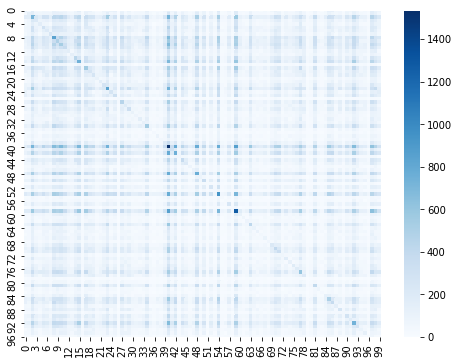

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(KAK.toarray(), cmap="Blues")

In [8]:
lc=100

Y_umap_2d = pickle.load(open("./data/Y_umap_2d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
Y_umap_3d = pickle.load(open("./data/Y_umap_3d_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

Y_mc_umap_2d = pickle.load(open("./data/Y_umap_2d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))
Y_mc_umap_3d = pickle.load(open("./data/Y_umap_3d_mc_K{}_topkevecs{}_drop{}_lc{}.p".format(k_neighbors, keep_k_evecs, drop_k_evecs, lc), 'rb'))

Y_c_umap_2d = cp.compute_centroids(Y_umap_2d, mc_cluster=False)
Y_c_umap_3d = cp.compute_centroids(Y_umap_3d, mc_cluster=False)
Y_mc_c_umap_2d = cp.compute_centroids(Y_mc_umap_2d, mc_cluster=True)
Y_mc_c_umap_3d = cp.compute_centroids(Y_mc_umap_3d, mc_cluster=True)

100%|██████████| 100/100 [00:00<00:00, 11152.10it/s]


  7%|▋         | 7/100 [00:00<00:01, 65.59it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


100%|██████████| 100/100 [00:00<00:00, 118.88it/s]


Done


100%|██████████| 100/100 [00:00<00:00, 3354.13it/s]


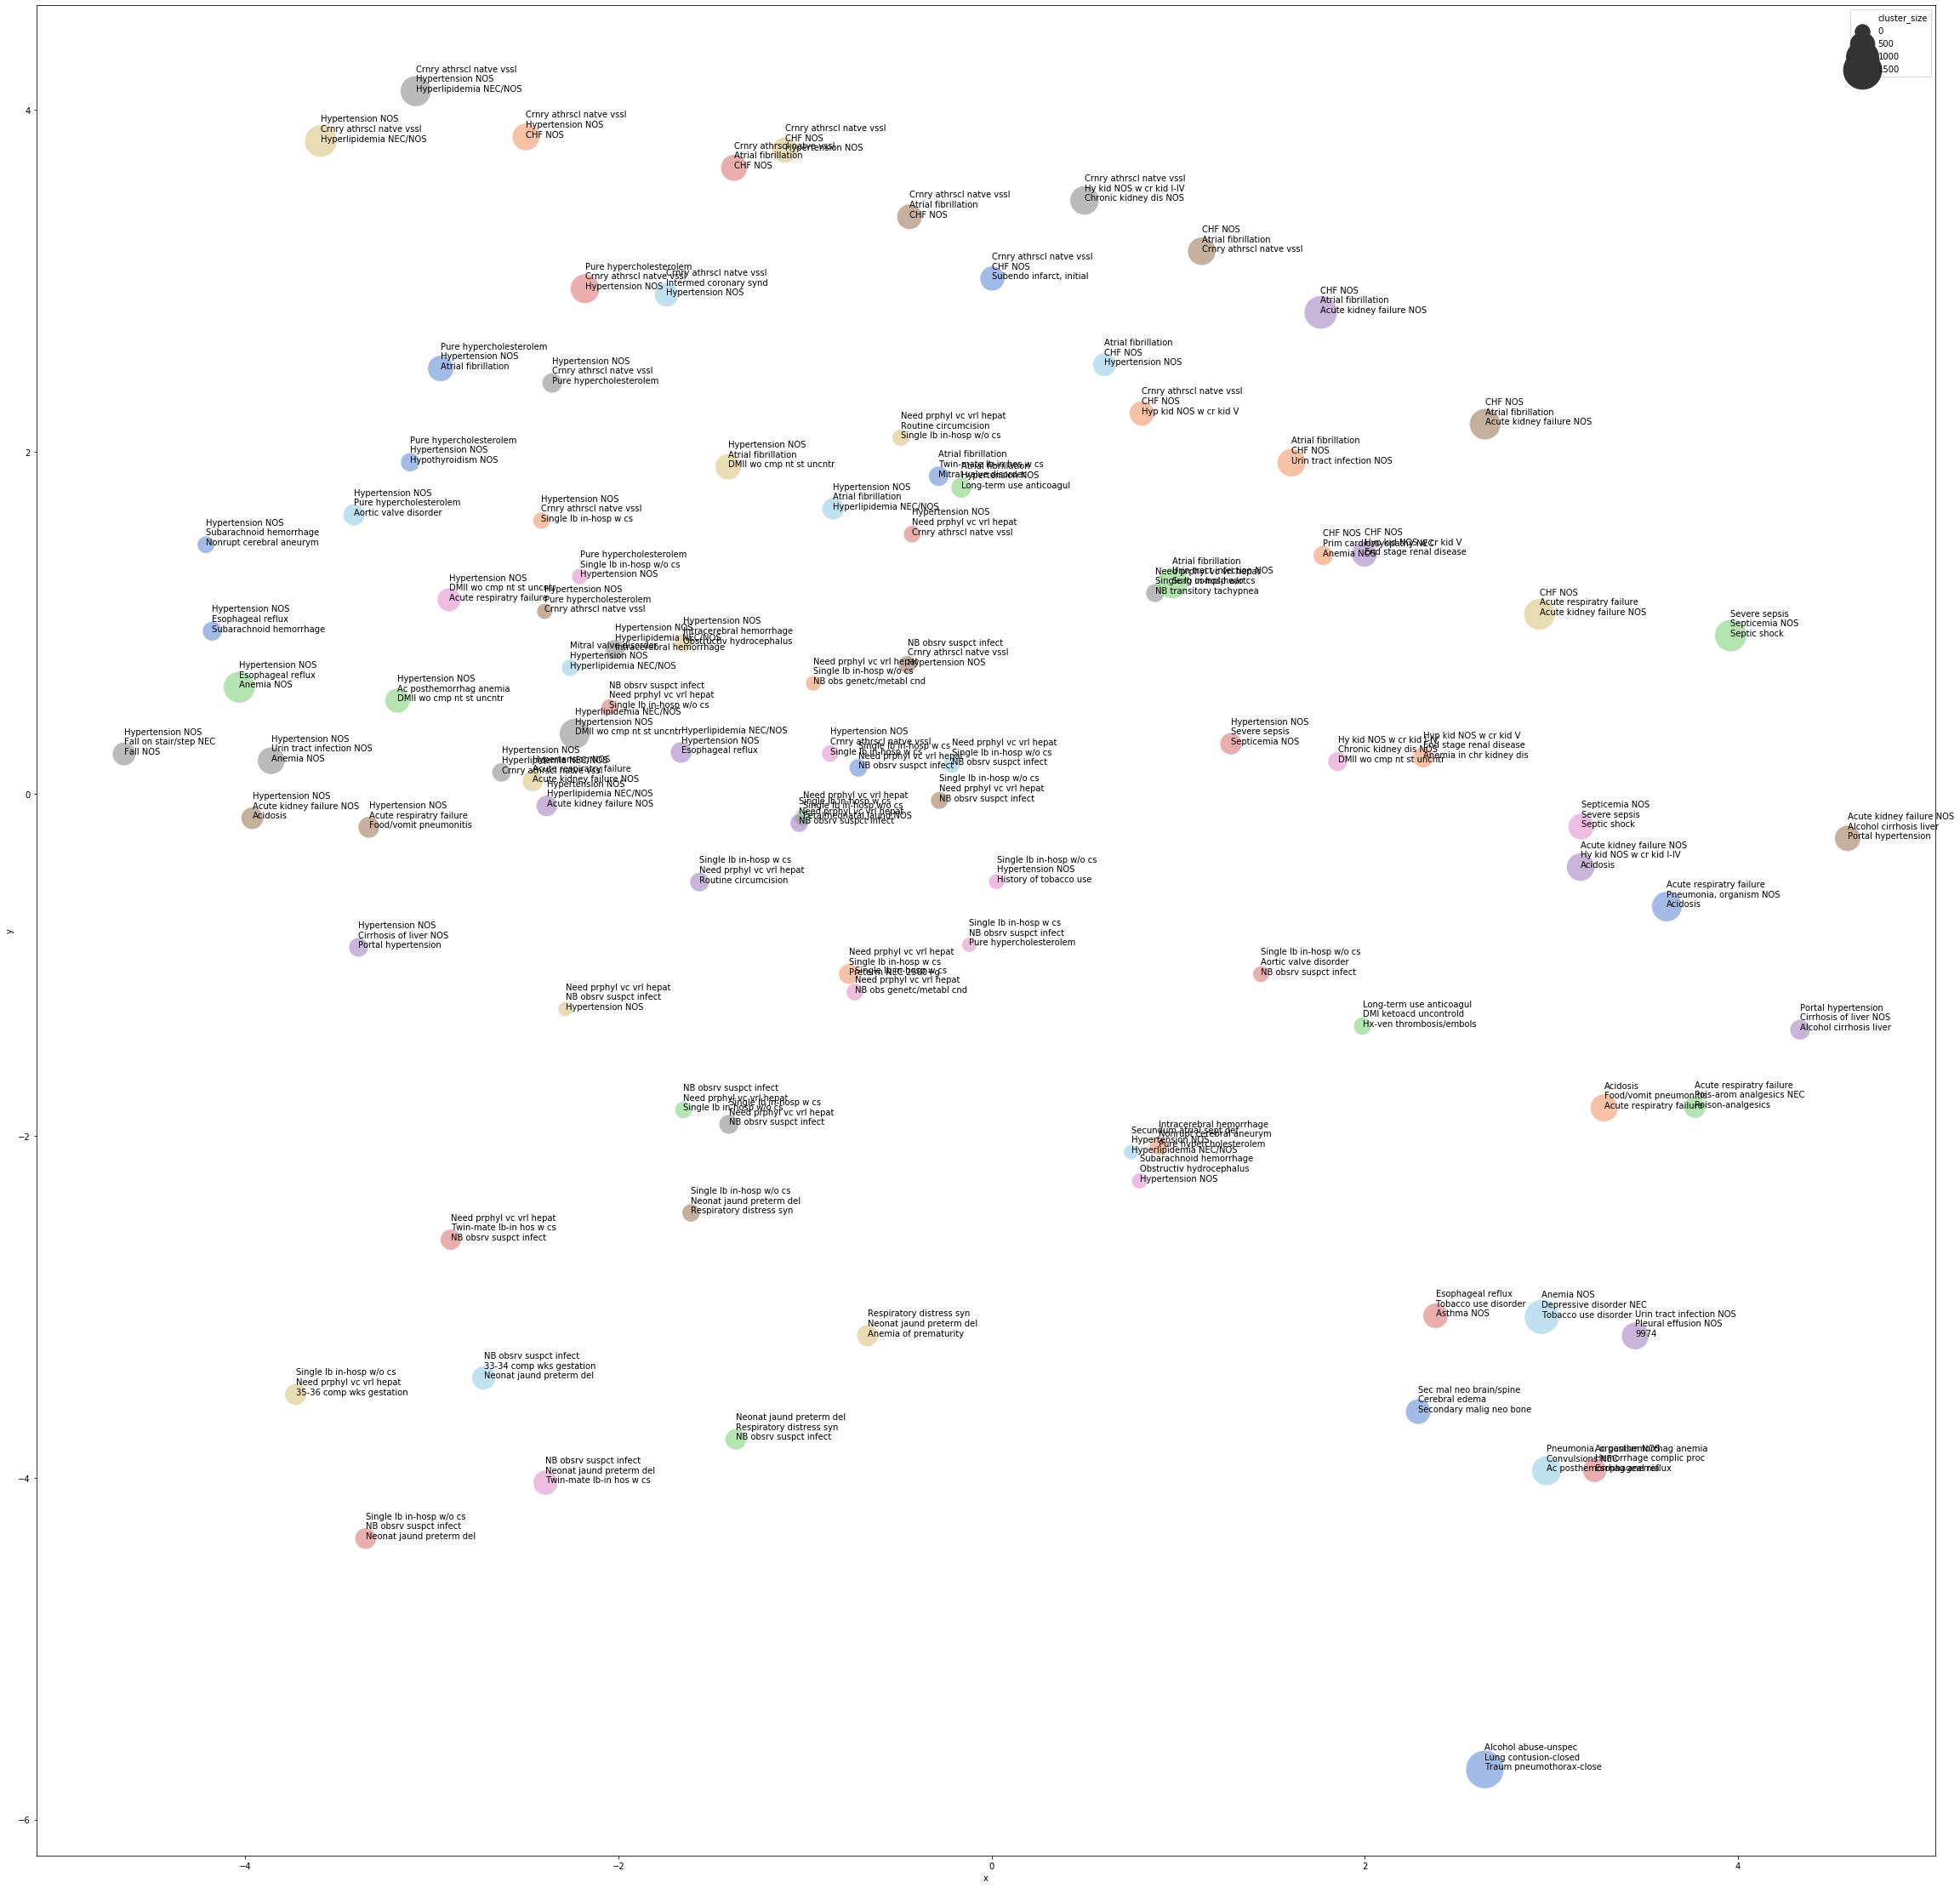

In [10]:
def create_centroid_cluster_df(y, cluster_labels, topk=3):
    centroids = cp.compute_centroids(y, mc_cluster=False)
    
    x = centroids[:, 0].tolist()
    y = centroids[:, 1].tolist()
    cluster_sizes = np.unique(cluster_labels, return_counts=True)[1].tolist()
        
    titles = ["" for _ in range(centroids.shape[0])]
    # print(len(titles))
    for c in tqdm(np.unique(cluster_labels)):
        top_k_df = cp.top_diseases_in_cluster(cluster=c, topk=3, short_title=True)
        # print(top_k_df)
        top_k_titles = top_k_df["SHORT_TITLE"].values.tolist()
        # print(top_k_titles)
        top_k_titles_asstr = "\n".join(top_k_titles)
        # print(top_k_titles_asstr)
        titles[c] = top_k_titles_asstr
        # break
        
        
    centroid_dict = {"x": x,
                     "y": y,
                     "cluster_size": cluster_sizes,
                     "cluster": np.unique(cluster_labels).tolist(),
                     "title": titles
                    }
    
    if centroids.shape[-1] == 3:
        z = centroids[:, 2].tolist()
        centroid_dict['z'] = z
        
    return pd.DataFrame(centroid_dict)

print(np.unique(Y_cluster_labels))


Y_2d_df = create_centroid_cluster_df(Y_umap_2d, Y_cluster_labels)
print("Done")
plt.figure(figsize=(40,40))
ax = sns.scatterplot(x="x", y="y", size="cluster_size", hue="cluster",
            sizes=(300, 2000), alpha=.5, palette="muted",
            data=Y_2d_df)
for line in tqdm(range(0,Y_2d_df.shape[0])):
     ax.text(Y_2d_df.x[line], Y_2d_df.y[line], Y_2d_df.title[line])

h,l = ax.get_legend_handles_labels()
plt.legend(h[-5:], l[-5:], loc="upper right")

plt.savefig("./figures/CLUSTER_PLOT_TOP_WORDS.png")